In [45]:
import torch
import numpy as np
import random

# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import torch.utils.data as data

In [181]:
import torchvision
from torch import nn
from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [46]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [47]:
def get_datapath_list(root_dir):
    
    root_dir = Path(root_dir)
    img_dir = root_dir / "JPEGImages"
    ann_dir = root_dir / "Annotations"
    
    train_id_name_txt = root_dir / "ImageSets" / "Main" / "train.txt"
    valid_id_name_txt = root_dir / "ImageSets" / "Main" / "val.txt"
    
    train_img_list = []
    train_ann_list = []
    
    for line in open(train_id_name_txt):
        file_id = line.strip()
        train_img_list.append(img_dir / f"{file_id}.jpg")
        train_ann_list.append(ann_dir / f"{file_id}.xml")
    
    valid_img_list = []
    valid_ann_list = []
    
    for line in open(valid_id_name_txt):
        file_id = line.strip()
        valid_img_list.append(img_dir / f"{file_id}.jpg")
        valid_ann_list.append(ann_dir / f"{file_id}.xml")

    return train_img_list, train_ann_list, valid_img_list, valid_ann_list

### ファイル確認

In [136]:
# ファイルパスのリストを作成
root_dir  = "./data/VOCdevkit/VOC2012/"
train_img_list, train_ann_list, val_img_list, val_ann_list = get_datapath_list(root_dir)

In [137]:
class Xml2ListConverter():
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path, widht, height):
        
        """
        
        [[xmin, ymin, xmax, ymax, label]...]
        """
        
        anno_list = []
        
        xml = ET.parse(xml_path).getroot()
        
        # 難しいもの削除
        for obj in xml.iter("object"):
            
            if int(obj.find('difficult').text) == 1:
                continue
                
            bnd_box = []
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')  
            
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in pts:
                #VOCの原点移動
                size = int(bbox.find(pt).text) - 1
                size = size/ height if pt.find("y") > -1 else size / width
                
                bnd_box.append(size)
            
            label_idx = self.classes.index(name)
            
            bnd_box.append(label_idx)
            
            anno_list.append(bnd_box)
   
        return np.array(anno_list)

In [50]:
# クラス定義
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

xml_converter = Xml2ListConverter(voc_classes)

ind = 10
image_file_path = val_img_list[ind]
# Pathlibば読めない
img = cv2.imread(str(image_file_path))  
height, width, channels = img.shape  

# アノテーションをリストで表示
xml_converter(val_anno_list[ind], width, height)

array([[0.888     , 0.67466667, 0.998     , 0.89066667, 6.        ]])

In [52]:
image_file_path

PosixPath('data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg')

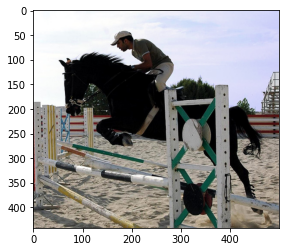

In [67]:
# 1. 画像読み込み
image_file_path = train_img_list[0]
img = cv2.imread(str(image_file_path))  
height, width, channels = img.shape  


# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Pillowでのデータ読み込み

In [62]:
from PIL import Image

In [68]:
img = Image.open(image_file_path)

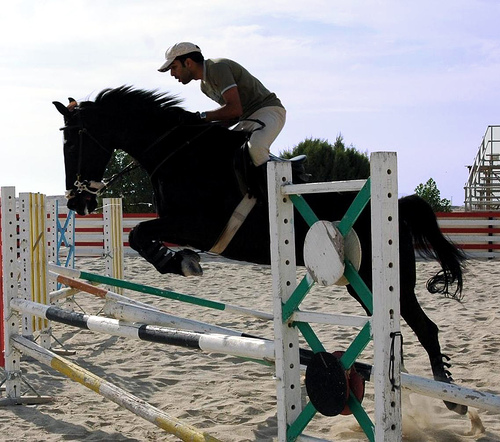

In [69]:
img

## データの前処理と準備 
- Datasetクラス
- Dataloader
- transfomerを作成

## Piplineを定義

In [132]:
class Pipeline():
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, img, boxes=None, labels=None):
        for transform in self.transforms:
            # 必ず引数が3つ必要
            # 予測時はboxes, labels共にNoneなので、それを前提に作成数するひつつ用あり
            img, boxes, labels = transform(img, boxes, labels)
        return img, boxes, labels

## データセット作成
- 最終的に 300×300にリサイズしたinputとそれにあうbounding boxができればよい

In [158]:
class VOCDataset(data.Dataset):
    def __init__(self, img_list, ann_list, transform, transform_ann):
        self.img_list = img_list
        self.ann_list = ann_list
        self.transform = transform # trainとvalidで異なる
        self.transform_ann = transform_ann
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        
        img = Image.open(self.img_list[index])
        h, w = img.size
        
        ann_path = self.ann_list[index]
        ann_list = self.transform_ann(ann_path, h, w)
        # 4はlabel name
        
        img, boxes, labels = self.transform(img, ann_list[:, :4], ann_list[:, 4])
        
        ans = torch.cat((boxes, labels.view(-1, 1)), axis=1)
        
        return img, ans 

## 画像処理

In [121]:
class Cutout:
    def __init__(self, n_holes=5, length=10):
        self.n_holes = n_holes
        self.length = length
    
    def __call__(self, img, box=None, labels=None):
        w, h = img.size
        img = np.array(img)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.

        for i in range(3):
            img[:, :, i] = img[:, :, i] * mask

        return Image.fromarray(np.uint8(img)), box, labels

In [224]:
class Resize:
    def __init__(self, size):
        self.resize = torchvision.transforms.Resize((size, size))
        
    def __call__(self, img, boxes=None, labels=None):
        img = self.resize(img)
        return img, boxes, labels

In [225]:
class SubtraceMeans:
    def __call__(self, im, boxes=None, labels=None):
        _im = np.array(im)
        _im = _im - _im.mean((0,1))
        return Image.fromarray(np.uint8(_im)), boxes, labels

In [226]:
class ToTensor:
    def __call__(self, img, box=None,labels=None):
        img = torchvision.transforms.ToTensor()(img)
        if not box is None:
            box = torch.tensor(box)
            labels = torch.tensor(labels)
        
        return img, box, labels

## Pipline追加

In [227]:
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

In [228]:
train_pipline = Pipeline([
    Cutout(),
    Resize(input_size),
    SubtraceMeans(),
    ToTensor()
    ])

valid_pipline = Pipeline([
    Resize(input_size),
    SubtraceMeans(),
    ToTensor()
])

In [229]:
ind = 6
ann_list = xml_converter(val_anno_list[ind], width, height)
img = Image.open(train_img_list[ind])

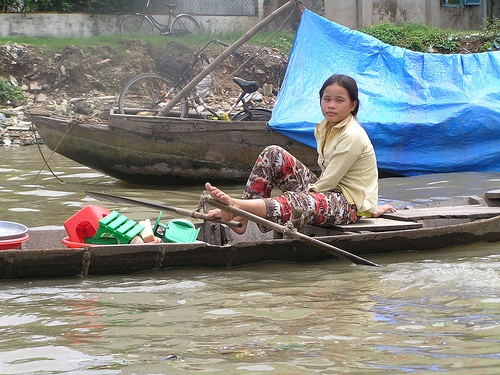

In [230]:
img

In [115]:
cutout = Cutout()

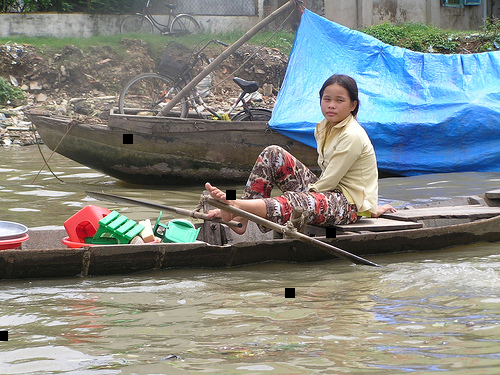

In [117]:
cutout(img)[0]

## データセット作成

In [232]:
train_dataset = VOCDataset(train_img_list, train_ann_list, transform=train_pipline, transform_ann=xml_converter)
val_dataset = VOCDataset(val_img_list, val_ann_list, transform=valid_pipline, transform_ann=xml_converter)

In [112]:
np.array(img).shape

(375, 500, 3)

In [113]:
img.size

(500, 375)

In [156]:
torch.cat( (torch.tensor(ann_list[:, :4]), torch.tensor(ann_list[:, 4]).view(-1, 1)), axis=1)

tensor([[2.4200e-01, 1.3575e-02, 7.4200e-01, 8.4615e-01, 1.4000e+01],
        [4.2000e-01, 3.3032e-01, 6.4800e-01, 5.7466e-01, 1.1000e+01]],
       dtype=torch.float64)

In [149]:
ann_list[:, 4]

array([14., 11.])

In [165]:
torch.tensor(ann_list[:, 4]).view(1, -1)

tensor([[14., 11.]], dtype=torch.float64)

## SSDのモデル作成
- VGGの中間表現を利用する

In [206]:
def make_vgg():
    layers = []
    in_channels = 3  # 色チャネル数

    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
            # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 動作確認
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [171]:
def make_extras():
    layers = [ ]
    in_channels = 1024
    
    # チャンネル
    c_config = [1024, 256, 512, 128, 256, 128, 256, 128, 256]
    k_config = [1, 3, 1, 3, 1, 3, 1, 3]
    s_config = [2, 1, 2, 1, 1, 1, 1, 1]
    p_config = [1, 0, 1, 0, 0, 0, 0, 0]
    
    for i, c in enumerate(c_config[:-1]):
        layers += [nn.Conv2d(c, c_config[i+1], kernel_size=k_config[i], 
                            stride=s_config[i], padding=p_config[i])]
    
    return nn.ModuleList(layers)

extras_test = make_extras()
extras_test

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)

- loc/confの実装

In [175]:
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    loc_layers = []
    conf_layers = []
    
    inp_config = [512, 1024, 512, 256, 256, 256]
    
    for i in range(len(bbox_aspect_num)):
        loc_layers += [nn.Conv2d(inp_config[i], bbox_aspect_num[i] * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(inp_config[i], bbox_aspect_num[i] * 4, kernel_size=3, padding=1)]
        
    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)
loc_layers, conf_layers = make_loc_conf()

- Normalize

In [188]:
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()
        
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale
        self.reset_parameters()
        self.eps = 1e-10
        
    def reset_parameters(self):
        init.constant_(self.weight, self.scale)

    def forward(self, x):
        '''38×38の特徴量に対して、512チャネルにわたって2乗和のルートを求めた
        38×38個の値を使用し、各特徴量を正規化してから係数をかけ算する層'''

        # 各チャネルにおける38×38個の特徴量のチャネル方向の2乗和を計算し、
        # さらにルートを求め、割り算して正規化する
        # normのテンソルサイズはtorch.Size([batch_num, 1, 38, 38])になります
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 係数をかける。係数はチャネルごとに1つで、512個の係数を持つ
        # self.weightのテンソルサイズはtorch.Size([512])なので
        # torch.Size([batch_num, 512, 38, 38])まで変形します
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

## デフフォルトボックス

In [194]:
class DBox:
    def __init__(self, config):
        super(DBox, self).__init__()
        
        self.image_size = config["input_size"]
        self.feature_maps = config["feature_maps"]
        self.num_priors = len(config["feature_maps"]) # 6
        self.pic_sizes = config["pix_sizes"] # DBのサイズ
        
        self.min_sizes = config["min_sizes"]
        self.max_sizes = config["max_sizes"]
        
        self.aspect_ratios = config["aspect_ratios"] # 長方形のアス比
        
    def make_dbox_list(self):
        mean = []
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                f_k = self.image_size / self.pic_sizes[k]
                # 
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k
                
                # アスペクト比1の小さいDBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # アスペクト比1の大きいDBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # その他のアスペクト比のdefBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        # DBoxをテンソルに変換 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBoxが画像の外にはみ出るのを防ぐため、大きさを最小0、最大1にする
        output.clamp_(max=1, min=0)

        return output

In [196]:
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'pix_sizes': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBoxの出力を確認する
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


- Bounding Box単位にoffsetと確信度を出す
- SSDでは細かい特徴量を使う
  特徴量のサイズ(次元が小さいほど)が画像のサイズ(が大きい)に相当する
- そうした特徴量を結合させて、予測を出す
  bounding boxごとに予測を出す.
  ここがすごい複雑

In [266]:
class SSD(nn.Module):
    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数=21

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # locとconfへの入力source1～6を格納
        loc = list()  # locの出力を格納
        conf = list()  # confの出力を格納

        # vggのconv4_3まで計算する
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3の出力をL2Normに入力し、source1を作成、sourcesに追加
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vggを最後まで計算し、source2を作成、sourcesに追加
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extrasのconvとReLUを計算
        # source3～6を、sourcesに追加
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLUをしたらsourceに入れる
                print("shape", x.shpae)
                print(x)
                sources.append(x)

        # source1～6に、それぞれ対応する畳み込みを1回ずつ適用する
        # zipでforループの複数のリストの要素を取得
        # source1～6まであるので、6回ループが回る
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)とc(x)で畳み込みを実行
            # l(x)とc(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremap幅]
            # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えて整える
            # permuteで要素の順番を入れ替え、
            # [minibatch数, featuremap数, featuremap数,4*アスペクト比の種類数]へ
            # （注釈）
            # torch.contiguous()はメモリ上で要素を連続的に配置し直す命令です。
            # あとでview関数を使用します。
            # このviewを行うためには、対象の変数がメモリ上で連続配置されている必要があります。

        # さらにlocとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928])
        # confのサイズはtorch.Size([batch_num, 183372])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 最後に出力する
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 推論時
            # クラス「Detect」のforwardを実行
            # 返り値のサイズは torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 学習時
            return output
            # 返り値は(loc, conf, dbox_list)のタプル

In [197]:
def decode(loc, dbox_list):
    # オフセット情報からBBoxを求める
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxesのサイズはtorch.Size([8732, 4])となります

    # BBoxの座標情報を[cx, cy, width, height]から[xmin, ymin, xmax, ymax] に
    boxes[:, :2] -= boxes[:, 2:] / 2  # 座標(xmin,ymin)へ変換
    boxes[:, 2:] += boxes[:, :2]  # 座標(xmax,ymax)へ変換

    return boxes

## Non-Maximus Suppression

In [198]:
# Non-Maximum Suppressionを行う関数


def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppressionを行う関数。
    boxesのうち被り過ぎ（overlap以上）のBBoxを削除する。

    Parameters
    ----------
    boxes : [確信度閾値（0.01）を超えたBBox数,4]
        BBox情報。
    scores :[確信度閾値（0.01）を超えたBBox数]
        confの情報

    Returns
    -------
    keep : リスト
        confの降順にnmsを通過したindexが格納
    count：int
        nmsを通過したBBoxの数
    """

    # returnのひな形を作成
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([確信度閾値を超えたBBox数])、要素は全部0

    # 各BBoxの面積areaを計算
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxesをコピーする。後で、BBoxの被り度合いIOUの計算に使用する際のひな形として用意
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socreを昇順に並び変える
    v, idx = scores.sort(0)

    # 上位top_k個（200個）のBBoxのindexを取り出す（200個存在しない場合もある）
    idx = idx[-top_k:]

    # idxの要素数が0でない限りループする
    while idx.numel() > 0:
        i = idx[-1]  # 現在のconf最大のindexをiに

        # keepの現在の最後にconf最大のindexを格納する
        # このindexのBBoxと被りが大きいBBoxをこれから消去する
        keep[count] = i
        count += 1

        # 最後のBBoxになった場合は、ループを抜ける
        if idx.size(0) == 1:
            break

        # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]

        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wとhのテンソルサイズをindexを1つ減らしたものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h

        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアの和（OR）の面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
        # IoUがoverlapより大きいidxは、最初に選んでkeepに格納したidxと同じ物体に対してBBoxを囲んでいるため消去

    # whileのループが抜けたら終了

    return keep, count

- 後で噛み砕く

In [199]:
class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  # confをソフトマックス関数で正規化するために用意
        self.conf_thresh = conf_thresh  # confがconf_thresh=0.01より高いDBoxのみを扱う
        self.top_k = top_k  # nm_supressionでconfの高いtop_k個を計算に使用する, top_k = 200
        self.nms_thresh = nms_thresh  # nm_supressionでIOUがnms_thresh=0.45より大きいと、同一物体へのBBoxとみなす

    def forward(self, loc_data, conf_data, dbox_list):
        """
        順伝搬の計算を実行する。

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            オフセット情報。
        conf_data: [batch_num, 8732,num_classes]
            検出の確信度。
        dbox_list: [8732,4]
            DBoxの情報

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num、クラス、confのtop200、BBoxの情報）
        """

        # 各サイズを取得
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # confはソフトマックスを適用して正規化する
        conf_data = self.softmax(conf_data)

        # 出力の型を作成する。テンソルサイズは[minibatch数, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_dataを[batch_num,8732,num_classes]から[batch_num, num_classes,8732]に順番変更
        conf_preds = conf_data.transpose(2, 1)

        # ミニバッチごとのループ
        for i in range(num_batch):

            # 1. locとDBoxから修正したBBox [xmin, ymin, xmax, ymax] を求める
            decoded_boxes = decode(loc_data[i], dbox_list)

            # confのコピーを作成
            conf_scores = conf_preds[i].clone()

            # 画像クラスごとのループ（背景クラスのindexである0は計算せず、index=1から）
            for cl in range(1, num_classes):

                # 2.confの閾値を超えたBBoxを取り出す
                # confの閾値を超えているかのマスクを作成し、
                # 閾値を超えたconfのインデックスをc_maskとして取得
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gtはGreater thanのこと。gtにより閾値を超えたものが1に、以下が0になる
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scoresはtorch.Size([閾値を超えたBBox数])
                scores = conf_scores[cl][c_mask]

                # 閾値を超えたconfがない場合、つまりscores=[]のときは、何もしない
                if scores.nelement() == 0:  # nelementで要素数の合計を求める
                    continue

                # c_maskを、decoded_boxesに適用できるようにサイズを変更します
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_maskをdecoded_boxesに適応します
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]で1次元になってしまうので、
                # viewで（閾値を超えたBBox数, 4）サイズに変形しなおす

                # 3. Non-Maximum Suppressionを実施し、被っているBBoxを取り除く
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids：confの降順にNon-Maximum Suppressionを通過したindexが格納
                # count：Non-Maximum Suppressionを通過したBBoxの数

                # outputにNon-Maximum Suppressionを抜けた結果を格納
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])

In [262]:
torch.tensor([2,3]).shape

torch.Size([2])

In [267]:
# SSDクラスを作成する


class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数=21

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # locとconfへの入力source1～6を格納
        loc = list()  # locの出力を格納
        conf = list()  # confの出力を格納

        # vggのconv4_3まで計算する
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3の出力をL2Normに入力し、source1を作成、sourcesに追加
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vggを最後まで計算し、source2を作成、sourcesに追加
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extrasのconvとReLUを計算
        # source3～6を、sourcesに追加
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLUをしたらsourceに入れる
                print("shape", x.shape)
                print(x)
                sources.append(x)

        # source1～6に、それぞれ対応する畳み込みを1回ずつ適用する
        # zipでforループの複数のリストの要素を取得
        # source1～6まであるので、6回ループが回る
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)とc(x)で畳み込みを実行
            # l(x)とc(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremap幅]
            # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えて整える
            # permuteで要素の順番を入れ替え、
            # [minibatch数, featuremap数, featuremap数,4*アスペクト比の種類数]へ
            # （注釈）
            # torch.contiguous()はメモリ上で要素を連続的に配置し直す命令です。
            # あとでview関数を使用します。
            # このviewを行うためには、対象の変数がメモリ上で連続配置されている必要があります。

        # さらにlocとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928])
        # confのサイズはtorch.Size([batch_num, 183372])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 最後に出力する
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 推論時
            # クラス「Detect」のforwardを実行
            # 返り値のサイズは torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 学習時
            return output
            # 返り値は(loc, conf, dbox_list)のタプル

## 損失関数の設計

In [201]:
def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1         # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prio

In [202]:
class MultiBoxLoss(nn.Module):
    """SSDの損失関数のクラスです。"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 関数matchのjaccard係数の閾値
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Miningの負と正の比率
        self.device = device  # CPUとGPUのいずれで計算するのか

    def forward(self, predictions, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        predictions : SSD netの訓練時の出力(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。

        targets : [num_batch, num_objs, 5]
            5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す

        Returns
        -------
        loss_l : テンソル
            locの損失の値
        loss_c : テンソル
            confの損失の値

        """

        # SSDモデルの出力がタプルになっているので、個々にばらす
        loc_data, conf_data, dbox_list = predictions

        # 要素数を把握
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # 損失の計算に使用するものを格納する変数を作成
        # conf_t_label：各DBoxに一番近い正解のBBoxのラベルを格納させる
        # loc_t:各DBoxに一番近い正解のBBoxの位置情報を格納させる
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tとconf_t_labelに、
        # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
        for idx in range(num_batch):  # ミニバッチでループ

            # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ラベル [物体1のラベル, 物体2のラベル, …]
            labels = targets[idx][:, -1].to(self.device)

            # デフォルトボックスを新たな変数で用意
            dbox = dbox_list.to(self.device)

            # 関数matchを実行し、loc_tとconf_t_labelの内容を更新する
            # （詳細）
            # loc_t:各DBoxに一番近い正解のBBoxの位置情報が上書きされる
            # conf_t_label：各DBoxに一番近いBBoxのラベルが上書きされる
            # ただし、一番近いBBoxとのjaccard overlapが0.5より小さい場合は
            # 正解BBoxのラベルconf_t_labelは背景クラスの0とする
            variance = [0.1, 0.2]
            # このvarianceはDBoxからBBoxに補正計算する際に使用する式の係数です
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 位置の損失：loss_lを計算
        # Smooth L1関数で損失を計算する。ただし、物体を発見したDBoxのオフセットのみを計算する
        # ----------
        # 物体を検出したBBoxを取り出すマスクを作成
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_maskをloc_dataのサイズに変形
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBoxのloc_dataと、教師データloc_tを取得
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 物体を発見したPositive DBoxのオフセット情報loc_tの損失（誤差）を計算
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # クラス予測の損失：loss_cを計算
        # 交差エントロピー誤差関数で損失を計算する。ただし、背景クラスが正解であるDBoxが圧倒的に多いので、
        # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようにする。
        # そこで背景クラスDBoxと予想したもののうち、損失が小さいものは、クラス予測の損失から除く
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # クラス予測の損失を関数を計算(reduction='none'にして、和をとらず、次元をつぶさない)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # 物体発見したPositive DBoxの損失を0にする
        # （注意）物体はlabelが1以上になっている。ラベル0は背景。
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ミニバッチごとの物体クラス予測の数
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 物体を発見したDBoxは損失0とする

        # Hard Negative Miningを実施する
        # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # （注釈）
        # 実装コードが特殊で直感的ではないです。
        # 上記2行は、要は各DBoxに対して、損失の大きさが何番目なのかの情報を
        # 変数idx_rankとして高速に取得したいというコードです。
        #
        # DBOXの損失値の大きい方から降順に並べ、DBoxの降順のindexをloss_idxに格納。
        # 損失の大きさloss_cの順位であるidx_rankを求める。
        # ここで、
        # 降順になった配列indexであるloss_idxを、0から8732まで昇順に並べ直すためには、
        # 何番目のloss_idxのインデックスをとってきたら良いのかを示すのが、idx_rankである。
        # 例えば、
        # idx_rankの要素0番目 = idx_rank[0]を求めるには、loss_idxの値が0の要素、
        # つまりloss_idx[?}=0 の、?は何番かを求めることになる。ここで、? = idx_rank[0]である。
        # いま、loss_idx[?]=0の0は、元のloss_cの要素の0番目という意味である。
        # つまり?は、元のloss_cの要素0番目は、降順に並び替えられたloss_idxの何番目ですか
        # を求めていることになり、 結果、
        # ? = idx_rank[0] はloss_cの要素0番目が、降順の何番目かを示すことになる。

        # 背景のDBoxの数num_negを決める。HardNegative Miningにより、
        # 物体発見のDBoxの数num_posの3倍（self.negpos_ratio倍）とする。
        # ただし、万が一、DBoxの数を超える場合は、DBoxの数を上限とする
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
        # 背景のDBoxの数num_negよりも、順位が低い（すなわち損失が大きい）DBoxを取るマスク作成
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # （終了）これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # マスクの形を整形し、conf_dataに合わせる
        # pos_idx_maskはPositive DBoxのconfを取り出すマスクです
        # neg_idx_maskはHard Negative Miningで抽出したNegative DBoxのconfを取り出すマスクです
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataからposとnegだけを取り出してconf_hnmにする。形はtorch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # （注釈）gtは greater than (>)の略称。これでmaskが1のindexを取り出す。
        # pos_idx_mask+neg_idx_maskは足し算だが、indexへのmaskをまとめているだけである。
        # つまり、posであろうがnegであろうが、マスクが1のものを足し算で一つのリストにし、それをgtで取得

        # 同様に教師データであるconf_t_labelからposとnegだけを取り出してconf_t_label_hnmに
        # 形はtorch.Size([pos+neg])になる
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidenceの損失関数を計算（要素の合計=sumを求める）
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 物体を発見したBBoxの数N（全ミニバッチの合計）で損失を割り算
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

In [268]:
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'pix_sizes': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの初期の重みを設定
# ssdのvgg部分に重みをロードする
#vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
#net.vgg.load_state_dict(vgg_weights)

# ssdのその他のネットワークの重みはHeの初期値で初期化


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [212]:
import torch.optim as optim

In [213]:
# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device="cpu")

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)

In [257]:
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。
    画像内の物体数が2個であれば(2, 5)というサイズですが、3個であれば（3, 5）など変化します。
    この変化に対応したDataLoaderを作成するために、
    カスタイマイズした、collate_fnを作成します。
    collate_fnは、PyTorchでリストからmini-batchを作成する関数です。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0].float())  # sample[0] は画像imgです
        #print(sample[1])
        targets.append(torch.FloatTensor(sample[1].float())) # sample[1] はアノテーションgtです

    # imgsはミニバッチサイズのリストになっています
    # リストの要素はtorch.Size([3, 300, 300])です。
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換します
    imgs = torch.stack(imgs, dim=0).float()

    # targetsはアノテーションデータの正解であるgtのリストです。
    # リストのサイズはミニバッチサイズです。
    # リストtargetsの要素は [n, 5] となっています。
    # nは画像ごとに異なり、画像内にある物体の数となります。
    # 5は [xmin, ymin, xmax, ymax, class_index] です

    return imgs, targets

In [217]:
num_epochs = 10
import time

In [264]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                         shuffle=False, num_workers=1, collate_fn=od_collate_fn)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                         shuffle=False, num_workers=1, collate_fn=od_collate_fn)

In [269]:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in train_loader:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ

                # optimizerを初期化
                optimizer.zero_grad()

                iteration += 1
                print("iter", iter)
                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()



使用デバイス： cuda:0
-------------
Epoch 1/10
-------------
（train）
iter <built-in function iter>
shape torch.Size([32, 512, 9, 9])
tensor([[[[5.8090e-03, 4.2155e-03, 4.2479e-03,  ..., 3.8579e-03,
           3.3918e-03, 0.0000e+00],
          [4.3467e-03, 8.7936e-03, 8.9674e-03,  ..., 8.8201e-03,
           8.8166e-03, 0.0000e+00],
          [4.8631e-03, 9.3434e-03, 9.9057e-03,  ..., 9.2048e-03,
           8.9239e-03, 0.0000e+00],
          ...,
          [5.0786e-03, 9.9042e-03, 1.0334e-02,  ..., 9.8706e-03,
           9.1313e-03, 0.0000e+00],
          [5.1394e-03, 1.0315e-02, 1.0709e-02,  ..., 9.7358e-03,
           8.8801e-03, 0.0000e+00],
          [0.0000e+00, 7.3403e-04, 1.1132e-03,  ..., 9.2454e-05,
           0.0000e+00, 0.0000e+00]],

         [[1.8898e-02, 3.5209e-02, 3.5944e-02,  ..., 3.4720e-02,
           3.4650e-02, 3.1969e-02],
          [9.2706e-03, 6.7045e-03, 7.4091e-03,  ..., 6.5244e-03,
           6.5503e-03, 1.6655e-03],
          [8.7625e-03, 6.0155e-03, 6.9334e-03,  .

RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

## 注意
いろいろ未完成な部分があるので、注意してください

後半は以下を参考にしました
- https://github.com/YutaroOgawa/pytorch_advanced/tree/master/2_objectdetection